In [1]:
from madigan.environments import make_env
from madigan.utils.preprocessor import StackerDiscrete
from madigan.utils.config import make_config

import numpy as np
import matplotlib.pyplot as plt

In [2]:
config_sine = make_config("sineComp", assets=["sineC1"],
                          data_source_type="SineAdder",
                          data_source_config={
                            'freq':[2.2, 4.1, 1., 3.],
                            'mu':[.6, 0.3, 2., 4.2],
                            'amp':[.5, 0.2, 0.4, 1.2],
                            'phase':[0., 1., 4., 0.],
                            'dX':0.01,
                            "noise": 0.0},
                         )
env_sine = make_env(config_sine)


In [3]:
config_ou = make_config("OU", assets=["ou1"],
                        data_source_type="OU",
                        data_source_config=dict(
                            mean=[10.],
                            theta=[.15],
                            phi = [4.],
                            noise_var = [.1])
                        )
env_ou = make_env(config_ou)

In [4]:
config_trend = make_config("SimpleTrend", assets=["trend1"],
                        data_source_type="SimpleTrend",
                        data_source_config=dict(
                            trend_prob=[.01],
                            min_period=[500],
                            max_period=[1500],
                            noise = [.0],
                            dYMin = [0.001],
                            dYMax = [0.005],
                            start = [5.0])
                        )
env_trend = make_env(config_trend)

In [5]:
config_composite = make_config("Composite", assets=["sine1", "trend1"],
                        data_source_type="Composite",
                        data_source_config=
                               {conf['data_source_type']: 
                                {'data_source_config': conf['data_source_config'],
                                 'data_source_type': conf['data_source_type']}
                               for conf in (config_sine, config_trend)}
                        )
env_composite = make_env(config_composite)

In [6]:
env_sine.nAssets, env_trend.nAssets

(1, 1)

In [7]:
window_sine = StackerDiscrete(128)
window_ou = StackerDiscrete(128)
window_trend = StackerDiscrete(1280)
window_composite = StackerDiscrete(1280)
window_sine.initialize_history(env_sine)
window_ou.initialize_history(env_ou)
window_trend.initialize_history(env_trend)

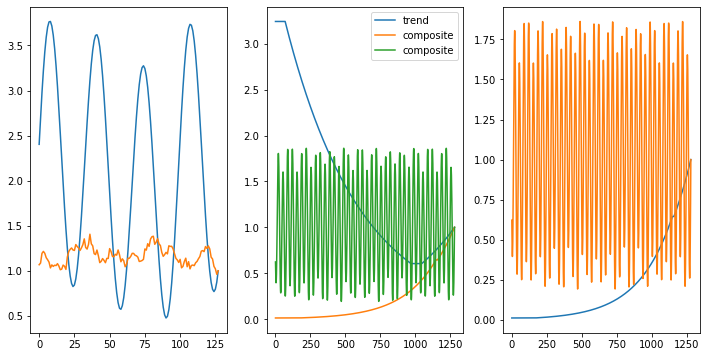

In [17]:
window_composite.reset_state()
window_composite.initialize_history(env_composite)
window_trend.reset_state()
window_trend.initialize_history(env_trend)

fig, ax = plt.subplots(1,3, figsize=(12, 6))
ax[0].plot(window_sine.current_data().price)
ax[0].plot(window_ou.current_data().price)
ax[1].plot(window_trend.current_data().price, label='trend')
ax[1].plot(window_composite.current_data().price, label='composite')
ax[2].plot(window_composite.current_data().price, label='composite')
ax[1].legend()

In [18]:
comSource = env_composite.dataSource
trendy, sineadder = comSource.dataSources()
trendy.currentData(), sineadder.currentData(), env_trend.dataSource.currentData()


(array([162578.19822209]), array([6.88839731]), array([1189.19914862]))

In [7]:
import numba

@numba.njit
def trend():
    x = 0.
    y = 5.
    dx = 0.01
    dy = 0.001
    trending = False
    directions = np.array((-1, 1))
    current_direction = directions[1]
    noise = 0.1
    trend_len=0
    while True:
        if trending:
            y += y*dy*current_direction 
            y = max(0.01, y)
            trend_len -= 1
            if trend_len == 0:
                trending=False
            if y <= 0.01:
                current_direction = 1
        else:
            if np.random.random() < 0.001:
                trending = True
                current_direction = np.random.choice(directions)
                trend_len = np.random.randint(low=500, high=1500)
        x += dx 
        y += noise * np.random.normal(0., noise)
        yield y
        

In [8]:
synth = iter(trend())

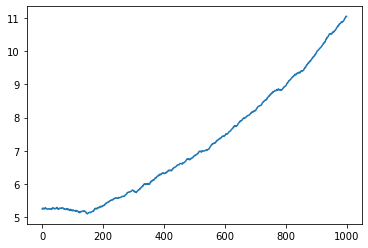

In [10]:
data = []
for i in range(1000):
    data.append(next(synth))
    
plt.plot(data)